# Case Study 1 : Data Science in Twitter Data

**Required Readings:** 
* Chapter 1 and Chapter 9 of the book [Mining the Social Web](http://cdn.oreillystatic.com/oreilly/booksamplers/9781449367619_sampler.pdf) 
* The codes for [Chapter 1](http://bit.ly/1qCtMrr) and [Chapter 9](http://bit.ly/1u7eP33)
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using Twitter Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using twitter data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

Superbowl commercials are usually a hot topic during the festival. Not only its price rate at 5 million dollars per 30 seconds, but also the impacting ideas catch eyes and generate rounds of conversations over the social medias.

Company would love to see people talking about their commercials at superbowl event, and expecting the finacial investment will bring treasure back. This study focuses on finding out the most popular commercials during superbowl events, via social media data collected on Twitter.























## Data Collection: Download Twitter Data using API

* In order to solve the above problem, you need to collect some twitter data. You could select a topic that is relevant to your problem, and use Twitter API to download the relevant tweets. It is recommended that the number of tweets should be larger than 200, but smaller than 1 million.
* Store the tweets you downloaded into a local file (txt file or json file) 

In [20]:
import twitter
import json
#---------------------------------------------
# Define a Function to Login Twitter API
def oauth_login():
    # Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'M8hkBNLeLsLrMJKOn7oOHD0aX'
    CONSUMER_SECRET ='EFGmOQVJgpk2XtDOZKImVuj6RIQnZBPOpHgPCq4nGc4vZeWlkl'
    OAUTH_TOKEN = '3252731651-zzGSOcP5K7PTs0GsTsvhu4VMfpHIW1eXT4BEiEu'
    OAUTH_TOKEN_SECRET = 'gs0cVor0pSuWlmnAXcsr8pTYcyOtqOTstKk1Q4ClsDQT5'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    #print(twitter_api.statuses.home_timeline())
    return twitter_api

#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

In [21]:
# Generate a twitter_api instance
twitter_api = oauth_login()

In [160]:
import time
from urllib2 import URLError
from httplib import BadStatusLine
#WORLD_WOE_ID = 1
#US_WOE_ID = 23424977


# Provide a uniform interface function for using twitter_api
def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw): 
    
    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print >> sys.stderr, 'Too many retries. Quitting.'
            raise e
    
        # See https://dev.twitter.com/docs/error-codes-responses for common codes
    
        if e.e.code == 401:
            print >> sys.stderr, 'Encountered 401 Error (Not Authorized)'
            return None
        elif e.e.code == 404:
            print >> sys.stderr, 'Encountered 404 Error (Not Found)'
            return None
        elif e.e.code == 429: 
            print >> sys.stderr, 'Encountered 429 Error (Rate Limit Exceeded)'
            if sleep_when_rate_limited:
                print >> sys.stderr, "Retrying in 15 minutes...ZzZ..."
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print >> sys.stderr, '...ZzZ...Awake now and trying again.'
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print >> sys.stderr, 'Encountered %i Error. Retrying in %i seconds' % \
                (e.e.code, wait_period)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function
    
    wait_period = 2 
    error_count = 0 

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except twitter.api.TwitterHTTPError, e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError, e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print >> sys.stderr, "URLError encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise
        except BadStatusLine, e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print >> sys.stderr, "BadStatusLine encountered. Continuing."
            if error_count > max_errors:
                print >> sys.stderr, "Too many consecutive errors...bailing out."
                raise

In [283]:
from collections import Counter


# Parse search result into several atributes
# Return: a dictionary with catogories 'words', 'retweet_count', 'favorite_count', 'screen_names', and 'hashtag'
def parseResult(statuses):
    status_texts = [ status['text'] for status in statuses ]

    words = [ w for t in status_texts
                    for w in t.split() ]
    
    retweet_count = [ status['retweet_count'] for status in statuses]
    
    favorite_count = [ status['favorite_count'] for status in statuses]
    
    followers_count = [ status['user']['followers_count'] for status in statuses]
    
    friends_count = [ status['user']['friends_count'] for status in statuses]
    
    entities = [status['entities'] for status in statuses]
    
    screen_names = [ user_mention['screen_name'] for status in statuses
                                                       for user_mention in status['entities']['user_mentions']]

    hashtags = [ hashtag['text'] for status in statuses
                                    for hashtag in status['entities']['hashtags'] ]  
    
    result = {}
    result['status_texts'] = status_texts
    result['words'] = words
    result['retweet_count'] = retweet_count
    result['favorite_count'] = favorite_count
    result['screen_names'] = screen_names
    result['hashtag'] = hashtags
    result['followers_count'] = followers_count
    result['friends_count'] = friends_count
    return result

In [315]:
# Word count function for selected catogorical list
# Return: top n-th (10 by default) largest from the list
def countTopFrequent(words, top = 10):
    for item in [words]:
        c = Counter(item)
    return c.most_common()[:top] # top 10 by default

In [195]:
from prettytable import PrettyTable


# Provide a pretty print function
# Input list of tuples on label and count frequency record
def prettyPrint(record, name_tag1, name_tag2):
    pt = PrettyTable(field_names=[name_tag1, name_tag2])
    [ pt.add_row(kv) for kv in record ]
    pt.align[name_tag1], pt.align[name_tag2] = 'l', 'r' # Set column alignment
    print pt

In [298]:
import io, json


# Providing saving and loading functions from json file
def save_json(filename, data):
    with io.open('/Users/easonjackson/Documents/DS501/{0}.json'.format(filename), 
                 'a', encoding='utf-8') as f:
        f.writelines(unicode(json.dumps(data, ensure_ascii=False)) + '\n')

def load_json(filename):
    with io.open('/Users/easonjackson/Documents/DS501/{0}.json'.format(filename), 
                 encoding='utf-8') as f:
        return f.read()

In [293]:
import sys
from functools import partial
from sys import maxint

def get_friends_followers_ids(twitter_api, screen_name=None, user_id=None,
                              friends_limit=maxint, followers_limit=maxint):
    
    # Must have either screen_name or user_id (logical xor)
    assert (screen_name != None) != (user_id != None), \
    "Must have screen_name or user_id, but not both"
    
    
    get_friends_ids = partial(make_twitter_request, twitter_api.friends.ids, 
                              count=500)
    get_followers_ids = partial(make_twitter_request, twitter_api.followers.ids, 
                                count=500)

    friends_ids, followers_ids = [], []
    
    for twitter_api_func, limit, ids, label in [
                    [get_friends_ids, friends_limit, friends_ids, "friends"], 
                    [get_followers_ids, followers_limit, followers_ids, "followers"]
                ]:
        
        if limit == 0: continue
        
        cursor = -1
        while cursor != 0:
        
            # Use make_twitter_request via the partially bound callable...
            if screen_name: 
                response = twitter_api_func(screen_name=screen_name, cursor=cursor)
            else: # user_id
                response = twitter_api_func(user_id=user_id, cursor=cursor)

            if response is not None:
                ids += response['ids']
                cursor = response['next_cursor']
        
            #print >> sys.stderr, 'Fetched {0} total {1} ids for {2}'.format(len(ids), 
            #                                        label, (user_id or screen_name))
        
            # XXX: You may want to store data during each iteration to provide an 
            # an additional layer of protection from exceptional circumstances
        
            if len(ids) >= limit or response is None:
                break

    # Do something useful with the IDs, like store them to disk...
    return friends_ids[:friends_limit], followers_ids[:followers_limit]

In [415]:
def get_user_profile(twitter_api, screen_names=None, user_ids=None):
   
    # Must have either screen_name or user_id (logical xor)
    assert (screen_names != None) != (user_ids != None), \
    "Must have screen_names or user_ids, but not both"
    
    items_to_info = {}

    items = screen_names or user_ids
    
    while len(items) > 0:

        # Process 100 items at a time per the API specifications for /users/lookup.
        # See https://dev.twitter.com/docs/api/1.1/get/users/lookup for details.
        
        items_str = ','.join([str(item) for item in items[:100]])
        items = items[100:]

        if screen_names:
            response = make_twitter_request(twitter_api.users.lookup, 
                                            screen_name=items_str)
        else: # user_ids
            response = make_twitter_request(twitter_api.users.lookup, 
                                            user_id=items_str)
    
        for user_info in response:
            if screen_names:
                items_to_info[user_info['screen_name']] = user_info
            else: # user_ids
                items_to_info[user_info['id']] = user_info

    return items_to_info

### Report  statistics about the tweets you collected 

In [338]:
# The total number of tweets collected:  < 2789 >
len(tweets_result)



2789

# Data Exploration: Exploring the Tweets and Tweet Entities

**(1) Word Count:** 
* Load the tweets you collected in the local file (txt or json)
* compute the frequencies of the words being used in these tweets. 
* Plot a table of the top 30 most-frequent words with their counts

In [332]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
tweets_result = []
with open('Tweets_collections.json', 'r') as curr_file:
    line = curr_file.readline()
    while line:
        tw = json.loads(line)
        tweets_result.append(tw)
        line = curr_file.readline()
    
words_collections = []
for tweet in tweets_result:
    words_collections += list(tweet['text'].split(' '))
top_words = countTopFrequent(words_collections, 30)
prettyPrint(top_words, 'Words', 'Count')


+------------------+-------+
| Words            | Count |
+------------------+-------+
| the              |  2070 |
| RT               |  1920 |
| commercial       |  1621 |
| #SuperBowl       |  1336 |
| a                |   911 |
| during           |   711 |
| for              |   563 |
| is               |   504 |
| to               |   497 |
| in               |   464 |
| @MonsterProducts |   417 |
| with             |   341 |
| you              |   336 |
| scenes           |   308 |
| Tide             |   300 |
| new              |   291 |
| behind           |   267 |
| they             |   263 |
| I                |   261 |
| our              |   255 |
| of               |   240 |
| but              |   238 |
| @VibeHubVR:      |   238 |
| took             |   233 |
| shoot.           |   233 |
| Founder          |   233 |
| #VIBEhub         |   233 |
| Alessio          |   233 |
| #vibec…          |   233 |
| pictures         |   233 |
+------------------+-------+


** (2) Find the most popular tweets in your collection of tweets**

Please plot a table of the top 10 most-retweeted tweets in your collection, i.e., the tweets with the largest number of retweet counts.


In [439]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
twitter_text = [tweet['text'] for tweet in tweets_result]
retweet_count = [tweet['retweet_count'] for tweet in tweets_result]

index = [i[0] for i in sorted(enumerate(retweet_count), key=lambda x:-x[1])]
twitter_text = [twitter_text[i] for i in index]
retweet_count = sorted(retweet_count, reverse = True)

dup = []
top_ten_tweets = []
top_ten_count = []
for i in range(len(index)):
    if len(top_ten_tweets) > 10:
        break;
    if twitter_text[i] not in dup:
        dup.append(twitter_text[i])
        top_ten_tweets.append(twitter_text[i])
        top_ten_count.append(retweet_count[i])
#top_ten_tweets = [twitter_text[i] for i in index][:10]
#top_ten_count = sorted(retweet_count, reverse = True)[:10]

pt = PrettyTable(field_names=['Tweet', 'Count'])
[ pt.add_row((kv1, kv2)) for (kv1, kv2) in zip(top_ten_tweets, top_ten_count) ]
pt.align['Tweet'], pt.align['Count'] = 'l', 'r' # Set column alignment
print pt


+----------------------------------------------------------------------------------------------------------------------------------------------+-------+
| Tweet                                                                                                                                        | Count |
+----------------------------------------------------------------------------------------------------------------------------------------------+-------+
| RT @slpng_giants: So @amazon can afford to run a 90 second commercial during the #Superbowl, but not pull ads off Breitbart, where they run… |   485 |
| RT @MichelobULTRA: Did you hear? @prattprattpratt is Michelob ULTRA’s new spokesperson. Watch him prepare to make this year’s #SuperBowl co… |   456 |
| RT @IGGYAZALEA: Shazam the #MonsterHeadphones #Superbowl commercial tonight to unlock behind the scenes footage! https://t.co/psWOEqQ3Vh     |   336 |
| RT @NathanZed: RHETT AND LINK IN A SUPERBOWL COMMERCIAL BREH. Literally the only

**(3) Find the most popular Tweet Entities in your collection of tweets**

Please plot the top 10 most-frequent hashtags and top 10 most-mentioned users in your collection of tweets.

In [437]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# 10 most-frequent hashtags
hashtags_collections = [word for word in words_collections if word.startswith(u'#')]
# 10 most-frequent screen_names
screen_names_collections = [word for word in words_collections if word.startswith(u'@')]

top_ten_hashtags = countTopFrequent(hashtags_collections)[:10]
top_ten_screen_names = countTopFrequent(screen_names_collections)[:10]

print
prettyPrint(top_ten_hashtags, 'Hashtag', 'Count')
print
prettyPrint(top_ten_screen_names, 'Screen name', 'Count')



+-----------------------+-------+
| Hashtag               | Count |
+-----------------------+-------+
| #SuperBowl            |  1336 |
| #vibe                 |   233 |
| #VIBEhub              |   233 |
| #vibec…               |   233 |
| #SBLII                |   213 |
| #Superbowl,           |   168 |
| #ReadyForUniversal    |   168 |
| #superbowlcommercials |   149 |
| #Superbowl            |    94 |
| #superbowl            |    93 |
+-----------------------+-------+

+-------------------+-------+
| Screen name       | Count |
+-------------------+-------+
| @MonsterProducts  |   417 |
| @VibeHubVR:       |   238 |
| @amazon           |   193 |
| @slpng_giants:    |   168 |
| @shadegossipfact: |   167 |
| @jarion_powell:   |   134 |
| @tide             |   119 |
| @UniversalORL:    |   105 |
| @YouTube          |    90 |
| @UniStudios:      |    63 |
+-------------------+-------+


Plot a histogram of the number of user mentions in the list using the following bins.

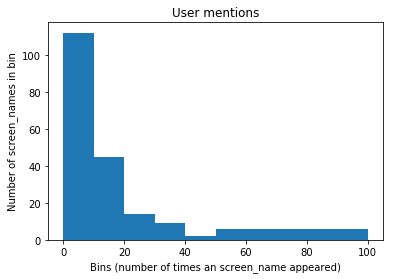

In [436]:
import matplotlib.pyplot as plt
#%matplotlib inline

bins=[0, 10, 20, 30, 40, 50, 100]

# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

def count2(list_input):
    for item in [list_input]:
        c = Counter(item)
    return c

plt.hist(count2(screen_names_collections).values(), bins = bins)

# Add a title and y-label ...
plt.title("User mentions")
plt.ylabel("Number of screen_names in bin")
plt.xlabel("Bins (number of times an screen_name appeared)")

plt.show()



 ** (4) Getting "All" friends and "All" followers of a popular user in the tweets**

* choose a popular twitter user who has many followers in your collection of tweets.
* Get the list of all friends and all followers of the twitter user.
* Plot 20 out of the followers, plot their ID numbers and screen names in a table.
* Plot 20 out of the friends (if the user has more than 20 friends), plot their ID numbers and screen names in a table.

In [418]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

# Get the most popular user screen_name
most_popular_user = top_ten_screen_names[0][0]
friends_ids, followers_ids = get_friends_followers_ids(twitter_api, screen_name = most_popular_user, friends_limit = 100, followers_limit = 100)

friends_profiles = get_user_profile(twitter_api, user_ids=friends_ids)
# select first 20 friends from the friends_profiles
friends = [(friends_profiles.keys()[i], friends_profiles.values()[i]['screen_name'])
                  for i in range(20)] # change 20 if not enough friends
# use follower ids to retrieve the follower screen names
followers_profiles = get_user_profile(twitter_api, user_ids=followers_ids)
# select the first 20 followers from the followers_profiles
followers = [(followers_profiles.keys()[i], followers_profiles.values()[i]['screen_name'])
                  for i in range(20)]

In [419]:
# plot the result 
print "Table for friends"
pt = PrettyTable(field_names=['ID numbers', 'Screen names'])
[ pt.add_row(friend) for friend in friends]
pt.align['ID numbers'], pt.align['Count'] = 'l', 'r' # Set column alignment
print pt

print

print "Table for followers"
pt = PrettyTable(field_names=['ID numbers', 'Screen names'])
[ pt.add_row(follower) for follower in followers]
pt.align['ID numbers'], pt.align['Count'] = 'l', 'r' # Set column alignment
print pt

Table for friends
+--------------------+-----------------+
| ID numbers         |   Screen names  |
+--------------------+-----------------+
| 857910454961700864 |  IUPUIUndergrad |
| 847540553415786497 |  IUCrimsonCard  |
| 813779053979336706 | bumblebeedrone1 |
| 350595075          |    LCHSBears    |
| 817893886026719236 |  keelllytaylor  |
| 704779912805220352 |    IUPUIOTEAM   |
| 707675871935668225 |     IUPUICRL    |
| 748898151050928130 |  FireworksINDY  |
| 426944019          |   IndianaRoof   |
| 3187077147         |   LColantonio2  |
| 789652803060768768 | littleworldofap |
| 294839340          |  LaurenStewart9 |
| 350500909          |   chuck_carney  |
| 289350733          |   PublicGreens  |
| 425419311          |     amyameir    |
| 2377799221         |      bmqiu      |
| 324978761          |   ErinButler3   |
| 180884045          |      Colts      |
| 1058881614         | christina_sekaz |
| 1928364624         |  king_nickelrod |
+--------------------+-----------------

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

# The approach is simply described as following steps:
* 1) Crawl tweets associated with superbowl events from twitter at a constant time interval.
* 2) Analyze the downloaded data to figure out belonging company of the commercial, retweet counts, favorite counts,
   and the number of friends/followers associated with the user of the tweets.
* 3) Format the collected data into json objects and stored locally.
* 4) Use mapreduce to process data, calculating the popularity of each brand/company's commercial.
* 5) Visualize the final result.








Write codes to implement the solution in python:

In [262]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary


# Load company names from the companies_seed json file
companies = []
with open('companies.txt') as f:
    line = f.readline()
    while line:
        name = line.strip()
        if name not in companies:
            companies.append(name)
        line = f.readline()


In [278]:
companies

['84 Lumber',
 'Airbnb',
 'American Petroleum Institute',
 'Anheuser-Busch InBev',
 'Audi',
 'Avocados From Mexico',
 'Bai Brands',
 'Buick',
 'Coca-Cola',
 'Pepsi',
 'Fiat Chrysler',
 'Fiji Water',
 'Ford',
 'GNC',
 'GoDaddy',
 'Google',
 'Honda',
 'H&R Block',
 'Hulu',
 'Intel',
 "It's A 10 Haircare",
 'KFC',
 'Kia',
 "King's Hawaiian",
 'Lexus',
 'Mercedes-Benz',
 'Michelin',
 'Mobile Strike',
 'Mr. Clean',
 'Netflix',
 'National Football League',
 'Nintendo',
 'Paramount',
 'Persil ProClean',
 'Proactiv',
 'Skittles',
 'Snickers',
 'SoFi',
 'Sony',
 'Sprint',
 'Squarespace',
 'Tide',
 'T-Mobile',
 'Top Games USA',
 'TurboTax',
 'Turkish Airlines',
 'WeatherTech',
 "Wendy's",
 'Wix.com',
 'Wonderful Pistachios',
 'World of Tanks',
 'Toyota',
 'Quicken Loans',
 'Intuit',
 'E*Trade',
 'Bud Light',
 'Amazon',
 'Michelob Ultra',
 'Mountain Dew and Doritos',
 'Monster',
 'Kraft',
 'Hyundai',
 'Budweiser',
 'Groupon',
 'Pringles',
 'Febreze',
 'Clorox',
 "M&M's",
 'Verizon',
 'YouTube',
 

In [331]:
import time


# For each company:
# A previous tweets collection is stored locally with a file 'company_name.json'
# To update the collection, firstly load a previous collection into a list,
# Using new data from twitts, checking first if the tweets exists, if not then append it to previous results
count = 1
hashtag_list = ['Superbowl', 'Superbowl commercial', 'Super Bowl Ads', 'Superbowl Ads', 'SuperBowl2018']
#companies = companies[:1]
def update_tweets(companies, result):
    tweets = []
    for text, retweet_num, fav_num, user_name, followers, friends \
    in zip(result['status_texts'], result['retweet_count'], 
           result['favorite_count'], result['screen_names'], 
           result['followers_count'], result['friends_count']):
        for company in companies:
            if company.lower() in text.lower():
                tw = {}
                tw['company'] = company
                tw['text'] = text
                tw['retweet_count'] = retweet_num
                tw['favorite_count'] = fav_num
                tw['influence'] = friends + followers
                tweets.append(tw)
    return tweets

while (count < 20):
    query_final_list = []
    for q in hashtag_list:
        query_result = make_twitter_request(twitter_api.search.tweets, q = 'Superbowl commercial', count = 1000)
        query_final_list = query_final_list + query_result ['statuses']    
    result = parseResult(query_final_list)
    
    curr_tweets = update_tweets(companies, result)
    
    for item in curr_tweets:
        save_json('Tweets_collections', item)
        
    print("Finished last round: " + str(count))
    time.sleep(60 * 20)
    count = count + 1

Finished last round: 1
Finished last round: 2
Finished last round: 3


KeyboardInterrupt: 

In [391]:
x = 0
while (x < 84):
    file1 = 'SuperbowlAds' + str(x) + '.txt'
    file2 = 'Superbowlad' + str(x) + '.txt'
    file3 = 'Superbowladd' + str(x) + '.txt'
    with open('data/' + file1, 'r') as infile:
        content_1 = parseResult(json.loads(infile.read()))

    with open('data/' + file2, 'r') as infile:
        content_2 = parseResult(json.loads(infile.read()))

    with open('data/' + file3, 'r') as infile:
        content_3 = parseResult(json.loads(infile.read()))
    print ('Done with ' + str(x))
    x += 1
    
tweets_new_version = []
tweets_new_version += update_tweets(companies, content_1)
tweets_new_version += update_tweets(companies, content_2)
tweets_new_version += update_tweets(companies, content_3)
for item in tweets_new_version:
        save_json('Tweets_collections_version2', item)
    

Done with 0
Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10
Done with 11
Done with 12
Done with 13
Done with 14
Done with 15
Done with 16
Done with 17
Done with 18
Done with 19
Done with 20
Done with 21
Done with 22
Done with 23
Done with 24
Done with 25
Done with 26
Done with 27
Done with 28
Done with 29
Done with 30
Done with 31
Done with 32
Done with 33
Done with 34
Done with 35
Done with 36
Done with 37
Done with 38
Done with 39
Done with 40
Done with 41
Done with 42
Done with 43
Done with 44
Done with 45
Done with 46
Done with 47
Done with 48
Done with 49
Done with 50
Done with 51
Done with 52
Done with 53
Done with 54
Done with 55
Done with 56
Done with 57
Done with 58
Done with 59
Done with 60
Done with 61
Done with 62
Done with 63
Done with 64
Done with 65
Done with 66
Done with 67
Done with 68
Done with 69
Done with 70
Done with 71
Done with 72
Done with 73
Done with 74
Done with 75
Done with 76
Done with

In [362]:
%%file tweet_popularity.py
from mrjob.job import MRJob
import json


class TweetPopularity(MRJob):
    def mapper(self, in_key, in_value):
        tw = json.loads(in_value)
        out_key = str(tw['company'])
        out_value = int(tw['retweet_count'] * tw['influence'] + tw['favorite_count'])
        yield (out_key, out_value)
        
    def reducer(self, in_key, in_value):
        out_key = in_key
        out_value = sum(in_value)
        yield (out_key, out_value)
    
# if __name__ == '__main__':
#     TweetPopularity.run()
        



Overwriting tweet_popularity.py


In [363]:
import tweet_popularity
reload(tweet_popularity)


data = open('Tweets_collections.json','r')
stdin = data.read()

# create a map reduce job (in a sandbox)
job = tweet_popularity.TweetPopularity(args=['Tweets_collections copy.json'])
job.sandbox(stdin=stdin)

# create a job runner
runner = job.make_runner()

# run the mapreduce job 
runner.run()

# parse the outputs
tweet_analysis_results = []
for line in runner.stream_output():
    # Use the job's specified protocol to read an output key-value pair
    key, value = job.parse_output_line(line)
    # append the value into a list 
    tweet_analysis_results.append([key,value])

In [406]:
tweet_analysis_results = sorted(tweet_analysis_results, key = lambda x: -x[1])
tweet_analysis_results

[[u'Monster', 139857113],
 [u'Amazon', 64417243],
 [u'Ford', 59353953],
 [u'Lexus', 51783523],
 [u'Universal', 48481534],
 [u'T-Mobile', 31840209],
 [u'YouTube', 21228900],
 [u'Tide', 20968894],
 [u'TurboTax', 17201340],
 [u'Budweiser', 9179095],
 [u'Pepsi', 2479891],
 [u'Toyota', 2356729],
 [u'Verizon', 2304420],
 [u'Michelob Ultra', 1376445],
 [u'Intuit', 806665],
 [u'Coca-Cola', 579640],
 [u'Squarespace', 526078],
 [u'Kia', 473147],
 [u'Hyundai', 409130],
 [u'Fiat Chrysler', 336162],
 [u'Pringles', 300632],
 [u'Audi', 156275],
 [u'Hulu', 134860],
 [u'Kraft', 91535],
 [u'WeatherTech', 61490],
 [u'Groupon', 47883],
 [u'Netflix', 47470],
 [u'Skittles', 33500],
 [u'Avocados From Mexico', 24405],
 [u'Febreze', 22560],
 [u'Nintendo', 14340],
 [u'Quicken Loans', 10760],
 [u'Sony', 15],
 [u'Mountain Dew and Doritos', 0],
 [u'Sprint', 0],
 [u'Stella Artois', 0],
 [u'Google', 0],
 [u'KFC', 0],
 [u'Bud Light', 0]]

In [311]:
with open('Tweets_collections.json', 'r') as f2:
    tw = json.loads(f2.readline())
    print(tw)
    out_key = str(tw['company'])
    out_value = int(tw['retweet_count'] * tw['influence'] + tw['favorite_count'])
    print(out_key, out_value)

{u'text': u'RT @UniStudios: #SuperBowl Commercial Premiere: Peyton Manning\u2026Vacation Quarterback #ReadyForUniversal #SBLII https://t.co/8oglrCWANe', u'company': u'Universal', u'retweet_count': 142, u'influence': 2081, u'favorite_count': 0}
('Universal', 295502)


# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


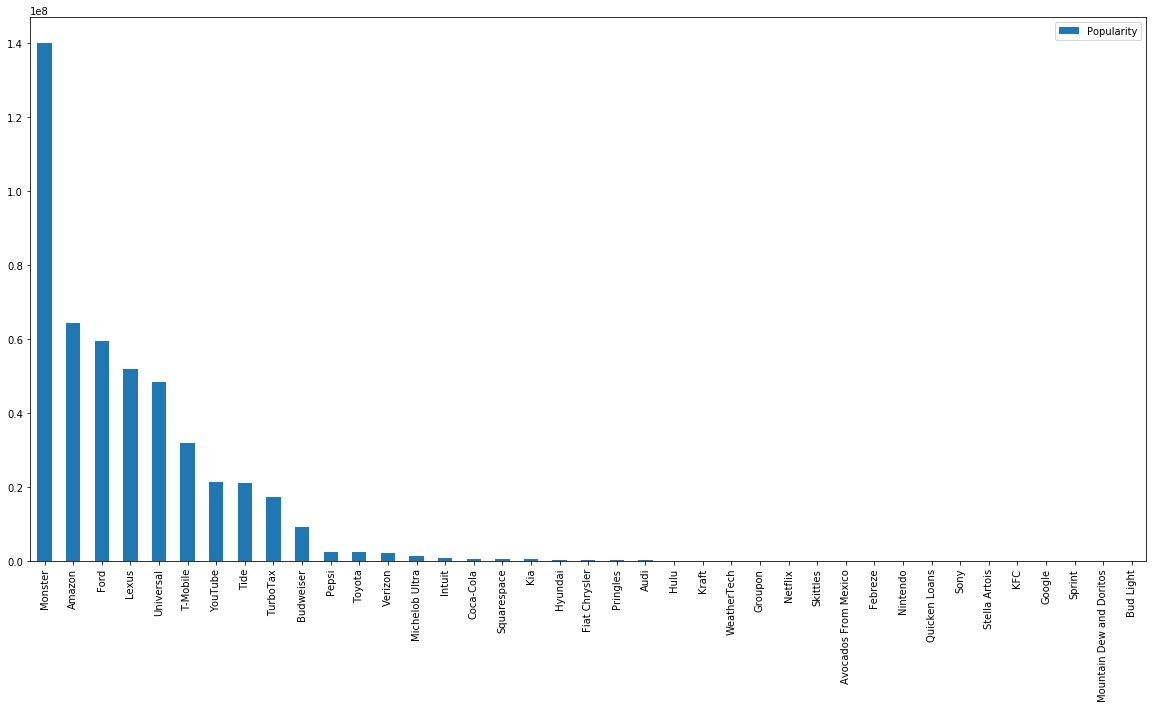

In [410]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary
import pandas

result_dict = {}
for rs in tweet_analysis_results:
    result_dict[str(rs[0])] = int(rs[1])
    
plt.figure(figsize = (50, 50))
df = pandas.DataFrame.from_dict(result_dict, orient='index',)
df.columns = ['Popularity']
df.sort_values(by='Popularity',ascending=False).plot(kind='bar',figsize = (20, 10))

In [373]:
result_dict

{'Amazon': 64417243,
 'Audi': 156275,
 'Avocados From Mexico': 24405,
 'Bud Light': 0,
 'Budweiser': 9179095,
 'Coca-Cola': 579640,
 'Febreze': 22560,
 'Fiat Chrysler': 336162,
 'Ford': 59353953,
 'Google': 0,
 'Groupon': 47883,
 'Hulu': 134860,
 'Hyundai': 409130,
 'Intuit': 806665,
 'KFC': 0,
 'Kia': 473147,
 'Kraft': 91535,
 'Lexus': 51783523,
 'Michelob Ultra': 1376445,
 'Monster': 139857113,
 'Mountain Dew and Doritos': 0,
 'Netflix': 47470,
 'Nintendo': 14340,
 'Pepsi': 2479891,
 'Pringles': 300632,
 'Quicken Loans': 10760,
 'Skittles': 33500,
 'Sony': 15,
 'Sprint': 0,
 'Squarespace': 526078,
 'Stella Artois': 0,
 'T-Mobile': 31840209,
 'Tide': 20968894,
 'Toyota': 2356729,
 'TurboTax': 17201340,
 'Universal': 48481534,
 'Verizon': 2304420,
 'WeatherTech': 61490,
 'YouTube': 21228900}

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 1".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (5 points) how well did the team describe the problem they are trying to solve using twitter data? 
       0: not clear
       1: I can barely understand the problem
       2: okay, can be improved
       3: good, but can be improved
       4: very good
       5: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection:
    ----------------------------------
    
    3. (10 points) Do you think the data collected are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale (> 300 tweets)
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    (1) Word Count (5 points):
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    (2) Find the most popular tweets in your collection of tweets: (5 points)
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    (3) Find popular twitter entities  (5 points)
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect

    (4) Find user's followers and friends (5 points)
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect

    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? 
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? 
       0: not relevant
       1: barely relevant to the problem
       2: okay solution, but there is an easier solution.
       3: good, but can be improved
       4: very good, but solution is simple/old
       5: innovative and technically sound
       
    7. how well did the team implement the solution in python? 
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? 
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think the results they found in the data? 
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  
       -1: I vote the other team is better than this team
        0: the same
        1: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9
       10: Team 10

